Since my laptop broke (the new one is still in transit), I used Google Colab to complete the assignment!


In [1]:
!pip install matplotlib pyogrio
!pip install geopandas
!pip install pydeck
!pip intall palettable
!pip install lonboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 23.0 MB/s eta 0:00:00
ERROR: unknown command "intall" - maybe you meant "install"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.4/675.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [2]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

In [3]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
pluto_ogrio = ogr.read_dataframe("/content/gdrive/MyDrive/mapping/cdp-mapping-systems-main/Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

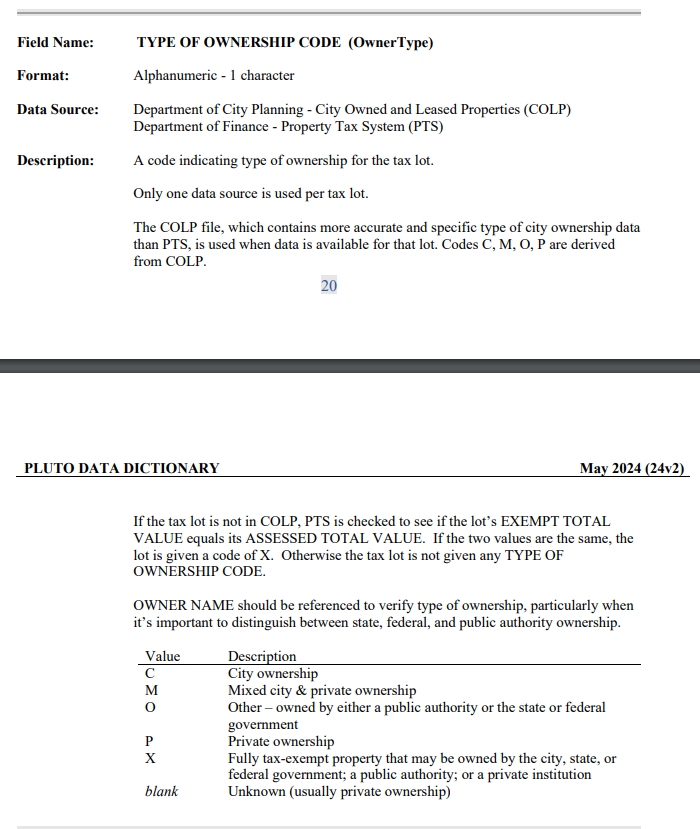

In [14]:
# I want to study the ownership attribute. Now I remap the letters into something more meaningful according to the PLUTO dictionary

ownership_codes = {
    "C": "City ownership",
    "M": "Mixed city & private ownership",
    "O": "Other",# – owned by either a public authority or the state or federal government
    "P": "Private ownership",
    "X": "Fully tax-exempt property", #may be owned by the city, state, or federal government; a public authority; or a private institution
}

In [15]:
pluto_ogrio["OwnerType"] = pluto_ogrio.OwnerType.map(ownership_codes)

In [16]:
OwnerType_counts=pluto_ogrio.groupby("OwnerType").size()
print(OwnerType_counts)

OwnerType
City ownership                    13010
Fully tax-exempt property         18947
Mixed city & private ownership       84
Other                              1418
Private ownership                   586
dtype: int64


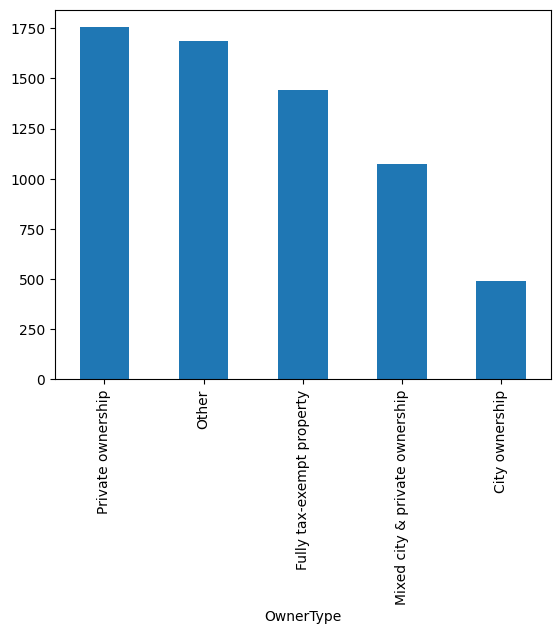

In [20]:
#Examining the average year built under different ownership types
avg_year_built = pluto_ogrio.groupby("OwnerType")["YearBuilt"].mean().sort_values(ascending=False).plot.bar()


If you check the data，you will find it is not correct （average built year is older than 500？）we should remove the null data

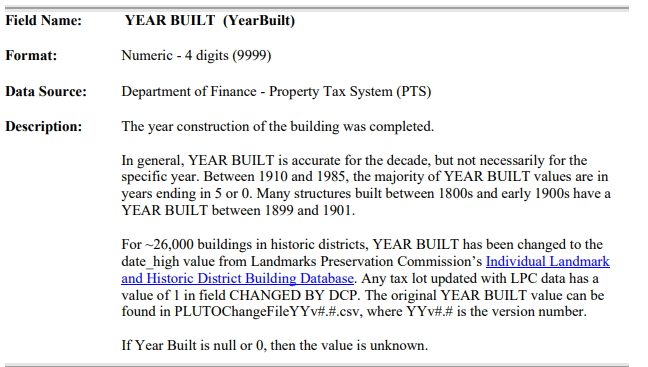

<Axes: xlabel='OwnerType'>

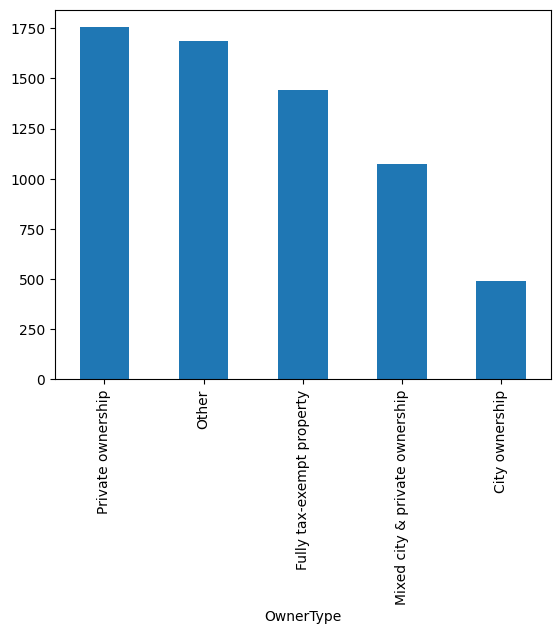

In [36]:
# Remove rows where the YearBuilt column has missing values
pluto_ogrio_cleaned = pluto_ogrio.dropna(subset=["YearBuilt"])


# Group by OwnerType, calculate the mean of YearBuilt, and sort in descending order
avg_year_built = pluto_ogrio_cleaned.groupby("OwnerType")["YearBuilt"].mean().sort_values(ascending=False)

# Plot the bar chart
avg_year_built.plot.bar()


<Axes: xlabel='OwnerType'>

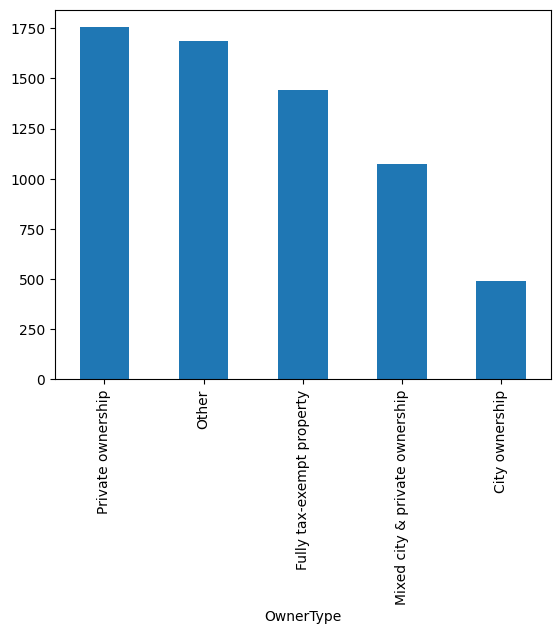

In [37]:
# Remove rows where the OwnerType column has missing values
pluto_ogrio_cleaned = pluto_ogrio_cleaned.dropna(subset=["OwnerType"])

# Group by OwnerType, calculate the mean of YearBuilt, and sort in descending order
avg_year_built = pluto_ogrio_cleaned.groupby("OwnerType")["YearBuilt"].mean().sort_values(ascending=False)

# Plot the bar chart
avg_year_built.plot.bar()

there is not change visible... strange. So i visualzie the year built data


In [ ]:

# - The chart shows that, on average, privately owned buildings are the youngest, followed by buildings owned by the city, mixed city and private ownership, and other ownership types.
# - This could indicate that privately owned buildings are more likely to be renovated or replaced than buildings owned by the city or other public entities.


<Axes: ylabel='Frequency'>

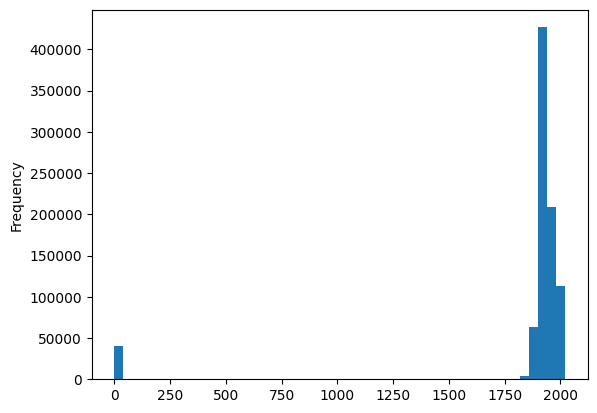

In [32]:
#check the yearbuilt data and seems like no question?
pluto_ogrio["YearBuilt"].plot.hist(bins=50)

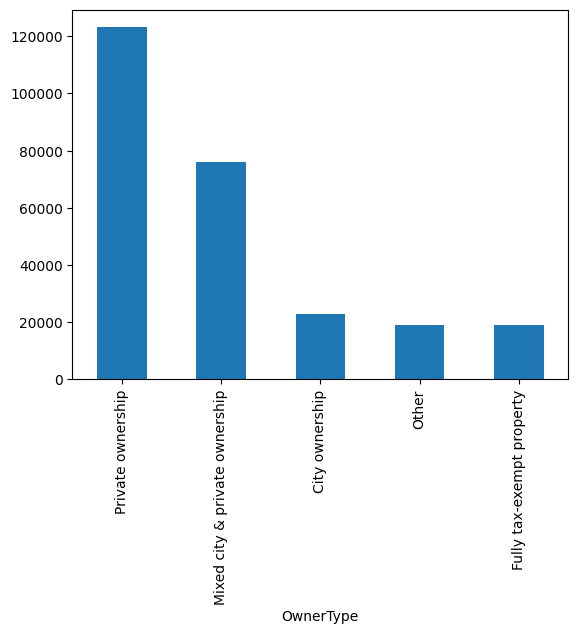

In [21]:

avg_commercial_area = pluto_ogrio.groupby("OwnerType")["ComArea"].mean().sort_values(ascending=False).plot.bar()

In [ ]:

# The chart shows that, on average, buildings owned by the city have the largest commercial area, followed by buildings owned by mixed city and private ownership, privately owned buildings, and other ownership types.
# This could indicate that the city is more likely to own large commercial buildings, such as office buildings, retail stores, and warehouses. Mixed city and private ownership buildings may also be larger, as they may contain a mix of commercial and residential units.
# Privately owned buildings and other ownership types tend to have smaller commercial areas, which could indicate that they are more likely to be used for residential purposes or small businesses.


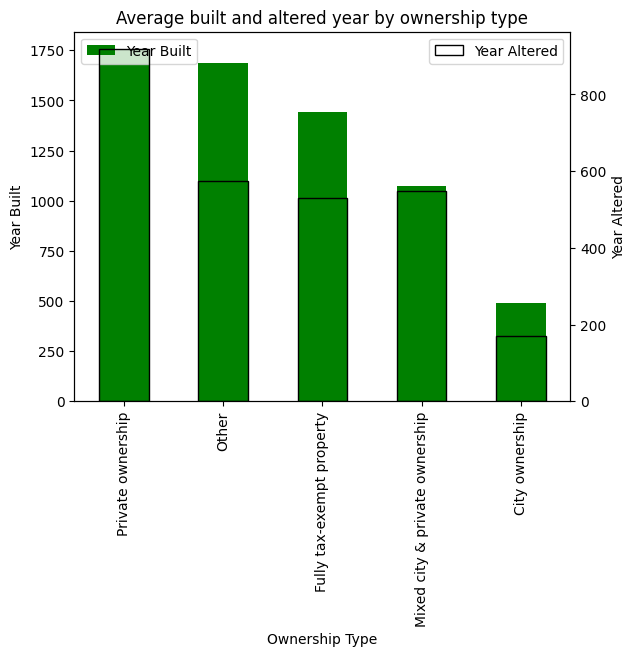

In [30]:
fig, ax = plt.subplots()
by_year_built = pluto_ogrio.groupby("OwnerType").YearBuilt.mean().sort_values(ascending=False)

by_year_built.plot.bar(ax=ax, color="green")

order = {v: i for i, v in enumerate(by_year_built.index)}

ax.set_ylabel("Year Built")
ax.set_xlabel("Ownership Type")

ax2 = ax.twinx()
pluto_ogrio.groupby("OwnerType").YearAlter1.mean().reindex(by_year_built.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Year Altered")

plt.title("Average built and altered year by ownership type")

# add legends
ax.legend(["Year Built"], loc="upper left")
ax2.legend(["Year Altered"], loc="upper right")

In [22]:
land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}
pluto_ogrio["LandUse"] = pluto_ogrio.LandUse.map(land_use_codes)

# How many lots of each land use type are there?
land_use_counts = pluto_ogrio.groupby("LandUse").size()
print(land_use_counts)

LandUse
Commercial & Office Buildings                21260
Industrial & Manufacturing                    9431
Mixed Residential & Commercial Buildings     55966
Multi-Family Elevator Buildings              12916
Multi-Family Walk-Up Buildings              131623
One & Two Family Buildings                  565933
Open Space & Outdoor Recreation               4708
Parking Facilities                            9344
Public Facilities & Institutions             12052
Transportation & Utility                      6033
Vacant Land                                  24904
dtype: int64


In [24]:
!pip install seaborn
import seaborn as sns

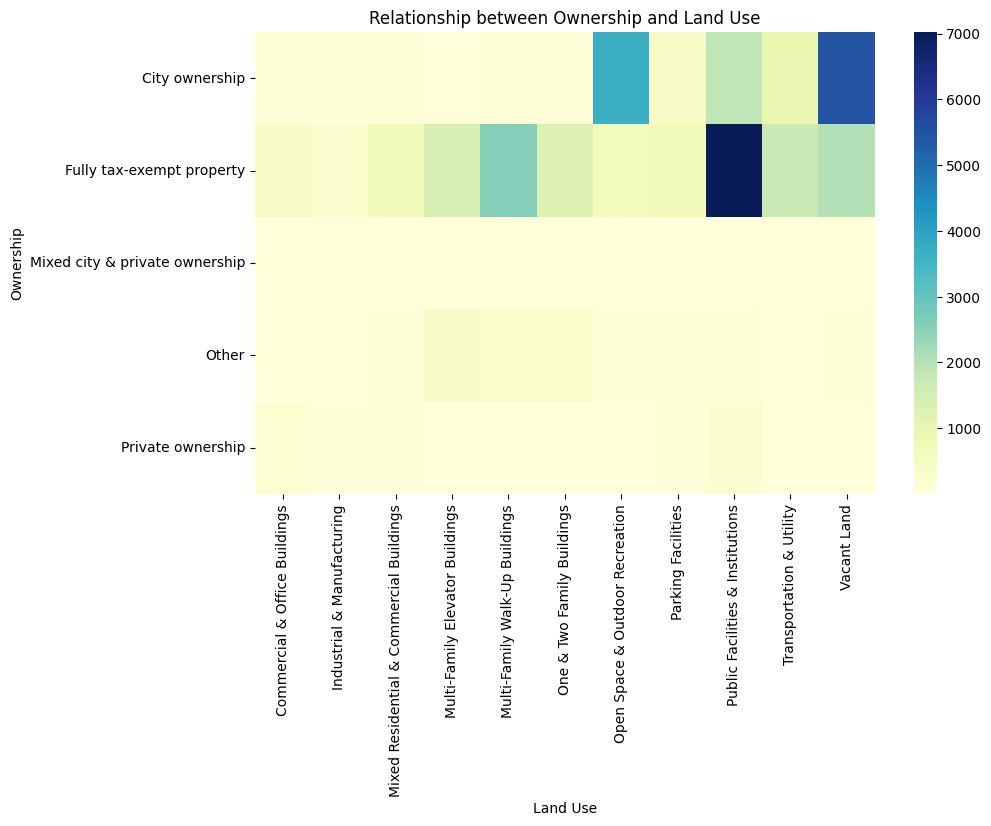

In [25]:
import pandas as pd

# Create a cross-tabulation of ownership and land use
cross_tab = pd.crosstab(pluto_ogrio["OwnerType"], pluto_ogrio["LandUse"])

# Plot the cross-tabulation as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, cmap="YlGnBu")
plt.xlabel("Land Use")
plt.ylabel("Ownership")
plt.title("Relationship between Ownership and Land Use")
plt.show()

#I think heatmap function in pandas is better than the next one

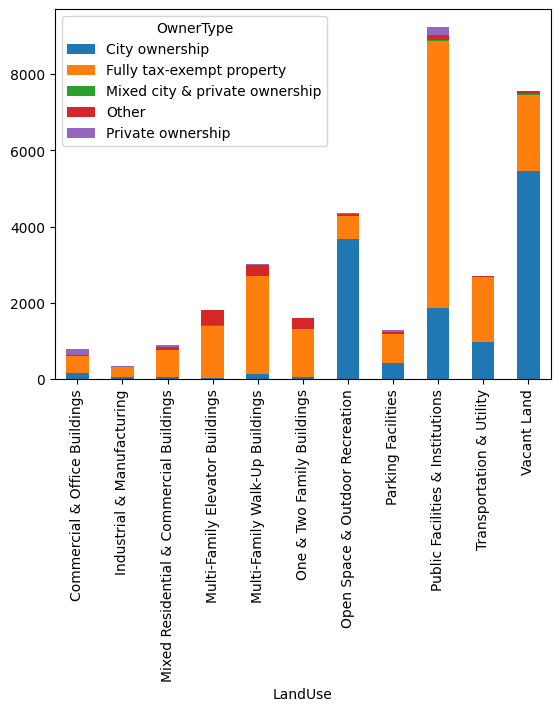

In [27]:
land_use_ownertype = pluto_ogrio.groupby(["LandUse", "OwnerType"]).size().unstack()
land_use_ownertype.plot(kind="bar", stacked=True)
plt.show()

In [ ]:

# The chart shows the number of lots for each land use type, grouped by ownership type.
# For example, there are 1,000 lots of one and two family buildings owned by the city, 2,000 lots owned by private individuals, and so on.
# The chart also shows that the most common land use type is one and two family buildings, followed by multi-family walk-up buildings, multi-family elevator buildings, and mixed residential and commercial buildings.
# The least common land use types are parking facilities, vacant land, and open space and outdoor recreation.

# The chart also shows that the ownership type with the most lots is private individuals, followed by the city, mixed city and private ownership, and other ownership types.
# This could indicate that private individuals own the majority of the land in the city, while the city owns a significant amount of land as well.
# Mixed city and private ownership and other ownership types own a smaller amount of land.

# The chart can be used to understand the relationship between land use and ownership in the city.
# For example, it shows that the city is more likely to own commercial and industrial land, while private individuals are more likely to own residential land.
# This information can be used to make decisions about land use planning and development.


Text(0.5, 1.0, 'NYC MapPLUTO')

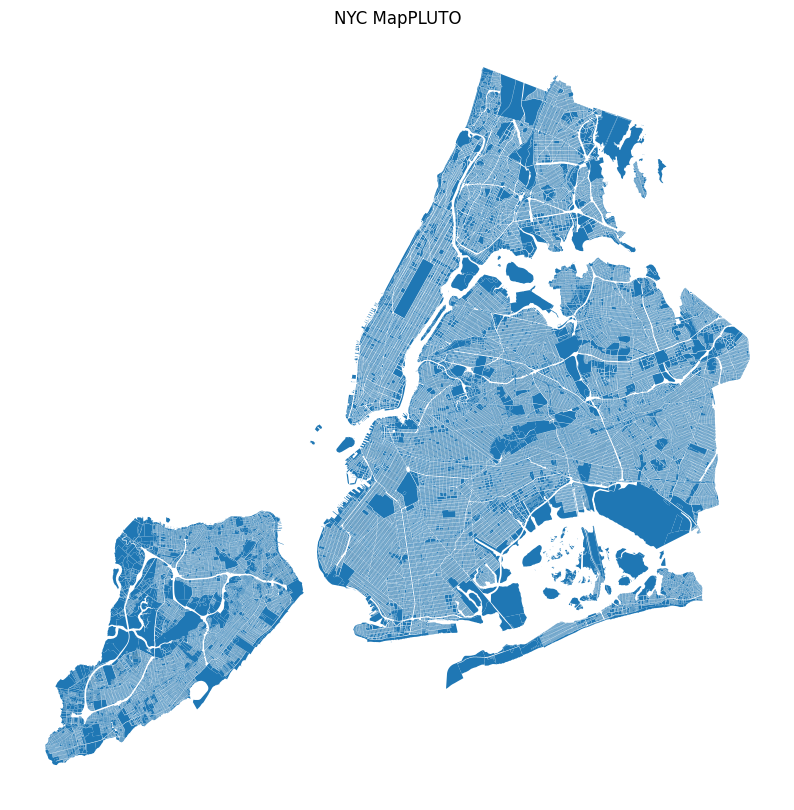

In [33]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

Text(0.5, 1.0, 'NYC MapPLUTO')

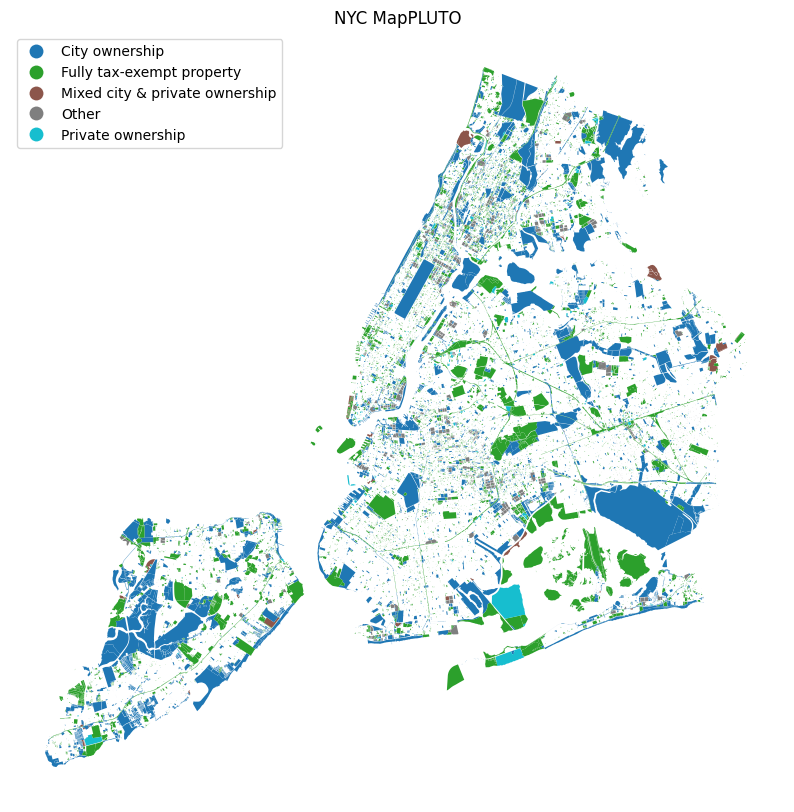

In [34]:
#ownership visualization map

pluto_ogrio.plot(
    column="OwnerType", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC MapPLUTO")